In [8]:
import tensorflow as tf
# import plotly.express as px
import matplotlib.pyplot as plt
from utils import *
import pandas as pd

In [9]:
directory = 'images/final/'
width = 96
height = 96
channels = 4
image_size = (width, height)
input_shape = (width, height, channels)
batch_size = 32

In [10]:
train_ds, class_names = load_data(directory, batch_size, image_size, GAN=True)

Found 13849 files belonging to 905 classes.


In [11]:
types = pd.read_csv('PokeDataset.csv', usecols=['Name', 'Type1', 'Type2'])
# reorder by alphabetical order of column 'Name'
types = types.sort_values(by=['Name'])
types = types.reset_index(drop=True)

In [12]:
# give percentage of pokemon with double type
print(f"Percentage of pokemon with double type: {types['Type2'].count() / types['Type1'].count() * 100:.2f}%")

Percentage of pokemon with double type: 50.69%


In [13]:
types.head(5)

,Name,Type1,Type2
0,Abomasnow,Grass,Ice
1,Abra,Psychic,NaN
2,Absol,Dark,NaN
3,Accelgor,Bug,NaN
4,Aegislash,Steel,Ghost


In [14]:
# make a dictionary of types and their index in the list of types
types_dict = {}
for i, t in enumerate(types['Type1'].unique()):
    types_dict[t] = i

# create vector of labels with 0 for each type except the one in the row (type1 and type2 are strings)
def create_label(row):
    label = np.zeros(18)
    label[types_dict[row['Type1']]] = 1
    if row['Type2'] in types_dict:
        label[types_dict[row['Type2']]] = 1
    return label

types['Label'] = types.apply(create_label, axis=1)

In [15]:
def types_to_vector(type1, type2=None):
    label = np.zeros(18)
    label[types_dict[type1]] = 1
    if type2 in types_dict:
        label[types_dict[type2]] = 1
    return label.reshape(1, 18)

In [16]:
for x, y in train_ds.take(1):
    print(int(tf.argmax(tf.reshape(y[0], [-1, 1]), axis=0)))
    plot_image(x[0], class_names[int(tf.argmax(tf.reshape(y[0], [-1, 1]), axis=0))], size=width)

521


In [17]:
# map labels in train_ds to the column Label in types
def map_labels(x, y):
    y_onehot = tf.argmax(y, axis=1).numpy()
    y_labels = np.zeros((len(y_onehot), 18))
    for i in range(len(y_onehot)):
        y_labels[i] = types.loc[y_onehot[i], 'Label']
    y_label = np.insert(y_labels, 0, 1, axis=1)
    y_label_tensor = tf.convert_to_tensor(y_label, dtype=tf.float32)
    return x, y_label_tensor



In [18]:
train_ds = prepare(train_ds, shuffle=True, augment=True, GAN=True)
train_ds = train_ds.map(lambda x, y: tf.py_function(map_labels, [x, y], [tf.float32, tf.float32]))

channels = 3
input_shape = (width, height, channels)

In [19]:
plot_n_images(train_ds, 5, class_names, GAN=True, size=width)

image shape :  (96, 96, 3)


In [20]:
from keras.layers import Input, Dense, Conv2D, Flatten, Lambda, Reshape, BatchNormalization, Concatenate, LeakyReLU, Dropout, Activation, UpSampling2D
from keras.models import Model
from keras import backend as K
import numpy as np


def define_encoder(input_shape, latent_dim):
    # Define the input shape
    input_shape = (96, 96, 3)

    # Define the number of latent variables
    latent_dim = 100

    # Define the encoder architecture
    input_encoder = Input(shape=input_shape, name='input_encoder')
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(input_encoder)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    z = Dense(latent_dim)(x)

    # Define the encoder model
    encoder = Model(input_encoder, z, name='encoder')

    return encoder


# Define the generator
def define_decoder(latent_dim):
    # Define the noise vector input
    in_lat = tf.keras.layers.Input(shape=(latent_dim,))
    # Define the class vector input
    # in_class = tf.keras.layers.Input(shape=(num_classes,))
    # Concatenate the noise and class vectors
    # merge = tf.keras.layers.Concatenate()([in_lat, in_class])
    # Project the concatenated vector to a larger dimension
    n = 128
    size = int(width/16)
    n_nodes = n * size * size
    dense = tf.keras.layers.Dense(n_nodes)(in_lat)
    # Reshape the dense layer output
    reshaped = tf.keras.layers.Reshape((size, size, n))(dense)
    # Upsample the feature maps
    upsampled = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(reshaped)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    # Output layer
    out_layer = tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same')(upsampled)
    # Define the model
    model = tf.keras.models.Model(in_lat, out_layer, name='decoder')
    return model

# # Define the sampler network
# def build_sampler(latent_dim):
#     # output_shape = input_shape
#     # Define the input layers for the mean and variance vectors
#     input_mean = tf.keras.layers.Input(shape=(latent_dim,))
#     input_var = tf.keras.layers.Input(shape=(latent_dim,))
#     # Define the sampling layer
#     def sampling(args):
#         mean, log_var = args
#         epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(mean)[0], latent_dim), mean=0., stddev=1.)
#         return mean + tf.keras.backend.exp(0.5 * log_var) * epsilon
#     # Connect the input layers to the sampling layer
#     sampled_latent = tf.keras.layers.Lambda(sampling)([input_mean, input_var])
#     # Connect the sampled latent vector to the decoder
#     # generated_image = decoder(sampled_latent)
#     # Define the sampler model
#     sampler = tf.keras.models.Model(inputs=[input_mean, input_var], outputs=sampled_latent, name='sampler')
#     return sampler


In [21]:
def build_discriminator(input_shape, latent_dim):
    # Define input layers
    img_input = Input(shape=input_shape)
    enc_input = Input(shape=(latent_dim,))

    # image branch
    img_layer = Conv2D(64, (3,3), strides=(2,2), padding='same')(img_input)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(128, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(256, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(512, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    # Flatten the features
    features = Flatten()(img_layer)

    # label branch
    latent_layer = tf.keras.layers.Dense(64)(enc_input)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(128)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(256)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(256)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Flatten()(latent_layer)

    # Concatenate the input layers
    merged_input = Concatenate()([features, latent_layer])
    merged_input = tf.keras.layers.Dropout(0.4)(merged_input)
    validity = Dense(1, activation='sigmoid')(merged_input)

    # Define the model
    model = Model(inputs=[img_input, enc_input], outputs=validity, name='discriminator')

    # compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


In [22]:
def build_vaegan(input_shape, latent_dim):
    # Define the encoder and decoder
    encoder = define_encoder(input_shape, latent_dim)
    decoder = define_decoder(latent_dim)

    # Define the discriminator
    discriminator = build_discriminator(input_shape, latent_dim)

    # Define the generator
    in_shape = tf.keras.layers.Input(shape=input_shape)
    encoded_latent = encoder(in_shape)
    gen_output = decoder(encoded_latent)

    # Freeze the discriminator weights during generator training
    discriminator.trainable = False

    # Define the GAN model
    gan_output = discriminator([gen_output, encoded_latent])
    gan_model = tf.keras.models.Model(in_shape, gan_output, name='gan')

    # Compile the GAN model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan_model.compile(loss='binary_crossentropy', optimizer=opt, experimental_run_tf_function=False)

    return decoder, discriminator, gan_model, encoder


In [23]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = tf.random.normal(shape=(n_samples, latent_dim))
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    noise_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(noise_input, verbose=0)
    # create 'fake' class labels (0)
    y_class = tf.zeros((n_samples, 1))
    return X, y_class, noise_input

def generate_real_samples(dataset, encoder, n_samples):
    X, y_class = [], []
    while len(X) < n_samples:
        dataset.shuffle(100)
        for x, label in dataset.take(5):
            for i in range(len(x)):
                X.append(x[i])
                y_class.append(label[i][0])
                if len(X) == n_samples:
                    break
            if len(X) == n_samples:
                break
    X = tf.stack(X)
    y_class = tf.reshape(tf.stack(y_class), (n_samples, 1))
    # generate points in latent space using encoder
    encoded = encoder.predict(X, verbose=0)
    return X, y_class, encoded


In [24]:
def summarize_performance(epoch, g_model, d_model, encoder, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real_class, encoded = generate_real_samples(dataset, encoder, n_samples)
    # evaluate discriminator on real examples
    # print(X_real.shape)
    # print(encoded.shape)
    # print(y_real_class.shape)
    X_reconstructed = g_model.predict(encoded, verbose=0)
    _, acc_real = d_model.evaluate([X_reconstructed, encoded], y_real_class, verbose=0)
    # prepare fake examples
    x_fake, y_fake_class, encoded = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate([x_fake, encoded], y_fake_class, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save_plot(X_real, epoch, reconstructions=1)
    save_plot(X_reconstructed, epoch, reconstructions=2)
    # save the generator model tile file
    filename = 'vaegenerator_model_96_e%03d.h5' % (epoch+1)
    g_model.save(filename)


def save_plot(examples, epoch, n=10, reconstructions=0):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # scale from [-1,1] to [0,1]
        examples[i, :, :, :] = (examples[i, :, :, :] + 1) / 2.0
        # plot raw pixel data
        plt.imshow(examples[i, :, :, :])
    # save plot to file
    if reconstructions == 0:
        filename = 'vae_generated_plot_96_e%03d.png' % (epoch+1)
    elif reconstructions == 1:
        filename = 'vae_reconstructions_1_plot_96_e%03d.png' % (epoch+1)
    else:
        filename = 'vae_reconstructions_2_plot_96_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [25]:
def train(g_model, d_model, encoder, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, resume_training=0):
    bat_per_epo = int(dataset.cardinality())
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j, batch in enumerate(dataset):
            # get randomly selected 'real' samples
            X_real, y_real_class = batch[0], batch[1][:, 0]
            half_batch = int(X_real.shape[0])
            encoded_real = encoder.predict(X_real, verbose=0)
            X_real_decoded = g_model.predict(encoded_real, verbose=0)
            # generate 'fake' examples
            X_fake, y_fake_class, noise_input = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            y_real_class = tf.reshape(y_real_class, (half_batch, 1))
            X, encoded, y_class = tf.concat([X_real_decoded, X_fake], axis=0), tf.concat([encoded_real, noise_input], axis=0), tf.concat([y_real_class, y_fake_class], axis=0)
            # update discriminator model weights
            # print(X, encoded, y_class)
            d_loss, _ = d_model.train_on_batch([X, encoded], y_class)
            # prepare points in latent space as input for the generator
            X_gan = tf.random.normal((n_batch, 96, 96, 3))
            y_gan_class = tf.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan_class)
            # summarize loss on this batch
            if j % 10 == 0:
                print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+resume_training+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+resume_training) % 2 == 0:
            summarize_performance(i+resume_training, g_model, d_model, encoder, dataset, latent_dim)
            pass
    # save the generator model
    g_model.save('vaegenerator_model_96_final.h5')


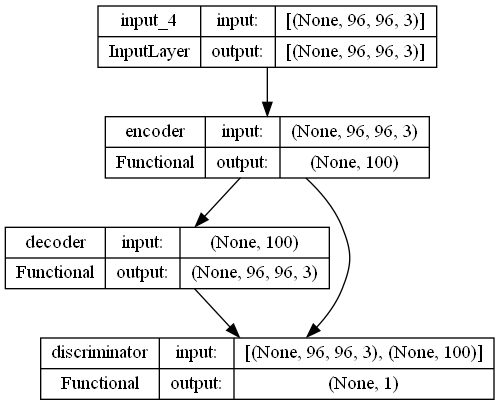

In [26]:
generator, discriminator, gan_model, encoder = build_vaegan(input_shape, latent_dim=100)
dot_img_file = '/VAEGAN.png'
tf.keras.utils.plot_model(gan_model, to_file=dot_img_file, show_shapes=True)

In [27]:
# size of the latent space
latent_dim = 100
# train model
train(generator, discriminator, encoder, gan_model, train_ds, latent_dim, n_epochs=11, resume_training=0)

>1, 1/433, d=0.685, g=0.725
>1, 11/433, d=0.659, g=0.796
>1, 21/433, d=0.624, g=0.861
>1, 31/433, d=0.601, g=0.943
>1, 41/433, d=0.540, g=0.927
>1, 51/433, d=0.444, g=0.982
>1, 61/433, d=0.363, g=1.154
>1, 71/433, d=0.268, g=1.352
>1, 81/433, d=0.170, g=1.394
>1, 91/433, d=0.129, g=1.510
>1, 101/433, d=0.087, g=1.634
>1, 111/433, d=0.078, g=1.590
>1, 121/433, d=0.047, g=1.216
>1, 131/433, d=0.039, g=1.438
>1, 141/433, d=0.026, g=1.009
>1, 151/433, d=0.023, g=1.066
>1, 161/433, d=0.028, g=0.976
>1, 171/433, d=0.016, g=0.603
>1, 181/433, d=0.023, g=0.641
>1, 191/433, d=0.014, g=0.639
>1, 201/433, d=0.009, g=0.817
>1, 211/433, d=0.007, g=0.822
>1, 221/433, d=0.010, g=0.506
>1, 231/433, d=0.005, g=0.544
>1, 241/433, d=0.004, g=0.488
>1, 251/433, d=0.004, g=0.340
>1, 261/433, d=0.005, g=0.239
>1, 271/433, d=0.008, g=0.312
>1, 281/433, d=0.011, g=0.339
>1, 291/433, d=0.003, g=0.320
>1, 301/433, d=0.003, g=0.161
>1, 311/433, d=0.001, g=0.203
>1, 321/433, d=0.002, g=0.128
>1, 331/433, d=0.002,

KeyboardInterrupt: 

test

In [17]:
generator = tf.keras.models.load_model('cgenerator_model_64_e131.h5')
discriminator = tf.keras.models.load_model('cdiscriminator_model_64.h5')

In [492]:
X = generator.predict([generate_latent_points(100, 1), types_to_vector('Ghost', 'Fighting')], verbose=0)
plot_image(X[0], "image générée", {"real": discriminator.predict([X, types_to_vector('Ghost', 'Fighting')], verbose=0)[0][0]}, 96)

In [ ]:
X = generator.predict([generate_latent_points(100, 1), np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])], verbose=0)
plot_image(X[0], "image générée", {"real": discriminator.predict([X, np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])], verbose=0)[0][0]}, 96)

In [91]:
# test image with random noise between -1 and 1
test_image_noise = tf.random.uniform(shape=(1, 96, 96, 3), minval=-1, maxval=1)

In [94]:
plot_image(test_image_noise[0], "image test", {"real": discriminator.predict([test_image_noise, types_to_vector('Dark')], verbose=0)[0][0]}, 96)

In [84]:
# load images/test/charmander.png to test
test_image = tf.keras.preprocessing.image.load_img('images/test/charmander.png', color_mode='rgba', target_size=image_size)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = tf.expand_dims(test_image, axis=0)
test_image = preprocess_image(test_image)
print(test_image.shape)

(1, 96, 96, 3)


In [192]:
# test discriminator with test image
plot_image(test_image[0], "image test", {"real": discriminator.predict([test_image, types_to_vector('Fire', 'Flying')], verbose=0)[0][0]}, 96)